In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import sparse
from functools import reduce
from collections import defaultdict
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
array_shape = (4,4)
telescope_number = np.prod(array_shape)
telescope_array = np.arange(telescope_number).reshape(array_shape)
tele_pos = [np.array(np.unravel_index(i, array_shape)) for i in range(telescope_number)]

In [4]:
def get_baseline_key(i1, i2, shape=array_shape):
    p1 = np.array(np.unravel_index(i1, shape))
    p2 = np.array(np.unravel_index(i2, shape))
    pos_diff = p1 - p2
    sign = np.product(pos_diff)
    if sign > 0:
        key = tuple(np.abs(pos_diff))
    else:
        key = tuple((np.abs(pos_diff[0]), -1*np.abs(pos_diff[1])))
    return key

In [5]:
def get_num_baselines(tele_num=telescope_number):
    # For square of N telescopes, should be 2N-2*sqrt(N) + 1
    # Fix to a corner and there are N-1 options for unique baselines. 
    # Flip over to other side (over x or y axis) and get another N-1 options
    # Duplicated are the pure x-axis and pure y-axis so -2*(sqrt(N)-1)
    # Final +1 is from 0 baseline
    
    N_bases = 2*tele_num - 2*np.sqrt(tele_num)
    return int(N_bases)

In [6]:
def get_baselines_np(tele_num=telescope_number):
    base_size = get_num_baselines(tele_num)
#     redundant_baselines = sparse.dok_matrix((base_size, tele_num, tele_num))
    redundant_baselines = np.zeros((base_size, tele_num, tele_num))
    baseline_indx = []
    for i in range(tele_num):
        for k in range(tele_num):
            if i==k:
                continue
            key = get_baseline_key(i,k)
            if key in baseline_indx:
                red_indx = baseline_indx.index(key)
                redundant_baselines[red_indx][i,k] = 1
            else:
                baseline_indx.append(key)
                redundant_baselines[len(baseline_indx)-1][i,k] = 1
    return redundant_baselines, baseline_indx

In [7]:
redundant_baselines, baseline_indx = get_baselines_np()
n_bases = get_num_baselines(telescope_number)

In [8]:
def get_baseline_indx(i1, i2, base_idx = baseline_indx):
    key = get_baseline_key(i1, i2)
    return base_idx.index(key)

In [9]:
rand_phases = lambda x: np.random.uniform(0, 2*np.pi, x)

In [10]:
npcb = np.vectorize(pow)

In [11]:
def make_gains(tele_num=telescope_number):
    gain_amp = np.abs(np.random.normal(1, .3, tele_num))
    gain_phase = rand_phases(tele_num)
    tgain = gain_amp*np.exp(1j*gain_phase)
    return tgain, gain_phase

In [12]:
def make_visibilities(tele_num=telescope_number):
    n_bases = get_num_baselines(telescope_number)
    sky_phase = rand_phases(n_bases)
    correl_sky = np.random.normal(3, .8, n_bases)*np.exp(1j*sky_phase)
    return correl_sky, sky_phase

In [13]:
def make_uv_points(tg, va, tele_num=telescope_number, noise_amp=.01, noise_sig=.005):
    observation_baselines = np.zeros((tele_num, tele_num), dtype=np.complex128)
    unsym_noise = np.random.normal(noise_amp, noise_sig, (tele_num, tele_num))*np.exp(1j*rand_phases((tele_num, tele_num)))
    noise_matrix = (unsym_noise + unsym_noise.T)*.5
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            key = get_baseline_key(i, k)
            red_indx = baseline_indx.index(key)
            if i < k:
                vaterm = va[red_indx]
                noise = noise_matrix[i,k]
            else:
                vaterm = np.conj(va[red_indx])
                noise = np.conj(noise_matrix[i,k])
            sig = tg[i]*np.conj(tg[k])*vaterm
            observation_baselines[i,k] = sig+noise
    return observation_baselines, noise_matrix

In [14]:
tgain, gain_phase = make_gains()
valpha, v_phase = make_visibilities()

In [15]:
observation_baselines, noises = make_uv_points(tgain, valpha)

In [16]:
snr = np.mean(np.abs(valpha)/np.mean(np.abs(noises)))
print("SNR is %f" % snr)

SNR is 402.020597


In [1196]:
gain_perturb = np.random.normal(.1,.02,telescope_number)*np.exp(1j*rand_phases(telescope_number))
va_perturb = np.random.normal(.4,.2,n_bases)*np.exp(1j*rand_phases(n_bases))

In [25]:
def omnical(iter_max, delta, garr, varr):
    y_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)
    w_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)+16
    ratio = np.zeros(iter_max)
    score = np.zeros(iter_max)
    chisqr = np.zeros(iter_max)
    
    for n in tqdm(range(iter_max)):
        oldx = np.concatenate((garr, varr))
        y_ij, _ = make_uv_points(garr, varr, noise_amp=0, noise_sig=0)
        
    #     gprime = garr*npcb(((w_ij*observation_baselines)/y_ij).sum(axis=1)/(w_ij.sum(axis=1)), 1/3)
        gdiv = np.divide(w_ij*observation_baselines, y_ij, out=np.zeros_like(w_ij), where=(y_ij!=0))
        gprime = garr * npcb(gdiv.sum(axis=1)/(w_ij.sum(axis=1)), 2/3)
        garr = (1 - delta)*garr + delta*gprime

        vprime = np.zeros(n_bases, dtype=np.complex128)
        for i in range(n_bases):
            indxs = np.where(redundant_baselines[i]==1)
            numer = ((w_ij[indxs]*observation_baselines[indxs])/y_ij[indxs]).sum()
            denom = (w_ij[indxs]).sum()
            vprime[i] = varr[i]*npcb(numer/denom, 1/3)
        varr = (1-delta)*varr + delta*vprime

#         gscale = 1/np.mean(np.abs(garr))
        gscale = 1
        vscale = (1/gscale)**2
        garr = garr*gscale
        varr = varr*vscale

        newx = np.concatenate((garr, varr))
        delx = newx - oldx
        step_r = np.linalg.norm(delx)/np.linalg.norm(oldx)
        ratio[n] = step_r
        score[n] = np.linalg.norm(y_ij - observation_baselines)
        chisqr[n] = (np.abs(observation_baselines - y_ij)**2).sum()
        if n > 20:
            if (chisqr[n] - chisqr[n-1]) > 0:
                break
    print(np.min(chisqr[chisqr.nonzero()]))
    return garr, varr, ratio, score, chisqr, n

In [35]:
gain_perturb = np.random.normal(.01, .005, telescope_number)*np.exp(1j*rand_phases(telescope_number))
valpha_perturb = np.random.normal(.05, .01, n_bases)*np.exp(1j*rand_phases(n_bases))

In [53]:
iter_max = 400
delta = .25

# g0 = 1*np.exp(1j*(gain_phase + (np.random.random(16)*2-1)/10))
# g0 = 1*np.exp(1j*rand_phases(telescope_number))
# g0 = 1*np.exp(1j*gain_phase)
g0 = tgain.copy() + gain_perturb*10
# v0 = 3*np.exp(1j*rand_phases(n_bases))
v0 = valpha.copy() + valpha_perturb*50

In [54]:
garr, varr, ratio, score, chisqr, finiters = omnical(iter_max, delta, g0, v0)


1141.0627165196618


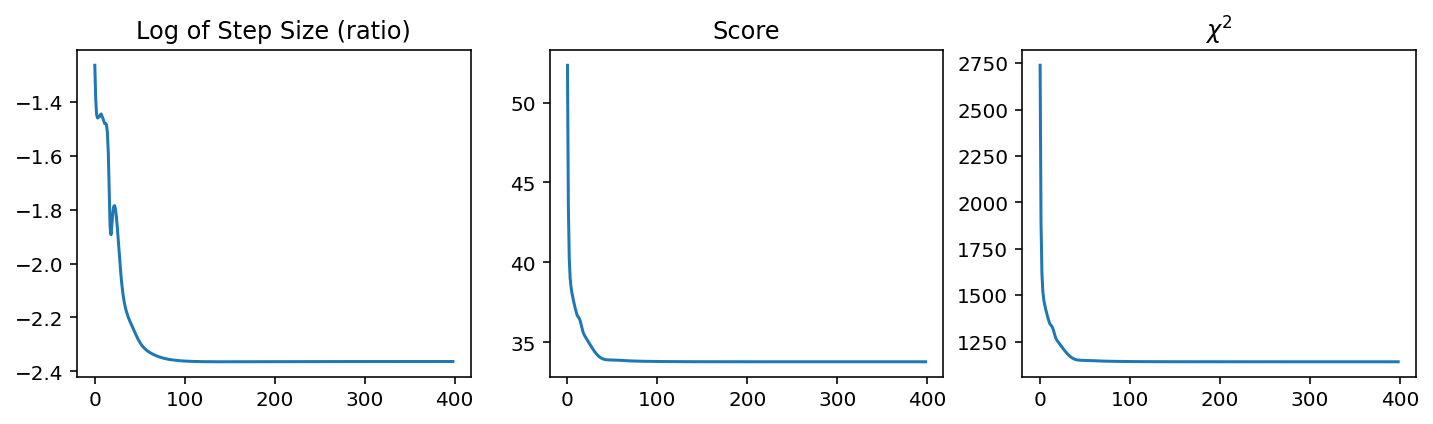

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

axes[0].plot(np.log10(ratio[:finiters]))
axes[0].set_title("Log of Step Size (ratio)")

axes[1].plot(score[:finiters])
axes[1].set_title("Score")

axes[2].plot(chisqr[:finiters])
axes[2].set_title(r"$\chi^2$");

In [56]:
gain_error = np.abs(tgain - garr)/np.abs(tgain)
v_error = (np.abs(valpha - varr)/np.abs(valpha))

In [57]:
print("Gain errors: ", gain_error)
print("Visibility errors: ", v_error)
print("Average errors: ", np.mean(gain_error), np.mean(v_error))

Gain errors:  [0.66741248 0.7205166  0.70022291 0.66118005 0.69084809 0.70710926
 0.68107847 0.66448741 0.6653225  0.68205799 0.70731875 0.68977621
 0.65998361 0.6991211  0.71824117 0.66662948]
Visibility errors:  [5.89376072 4.44910861 6.10908163 5.91340726 4.84207943 7.59597347
 7.53024627 7.94177497 1.97584891 4.18387676 5.57729913 7.48515931
 5.90386186 6.16005861 6.18874697 6.30997163 5.48641685 2.35419141
 7.26040921 6.33927833 2.96620077 7.51503261 5.15491724 3.02383733]
Average errors:  0.6863316308269197 5.590022469920355


In [58]:
title_mod = r"Perturbed $V_\alpha$ and g ($\approx 3$)"

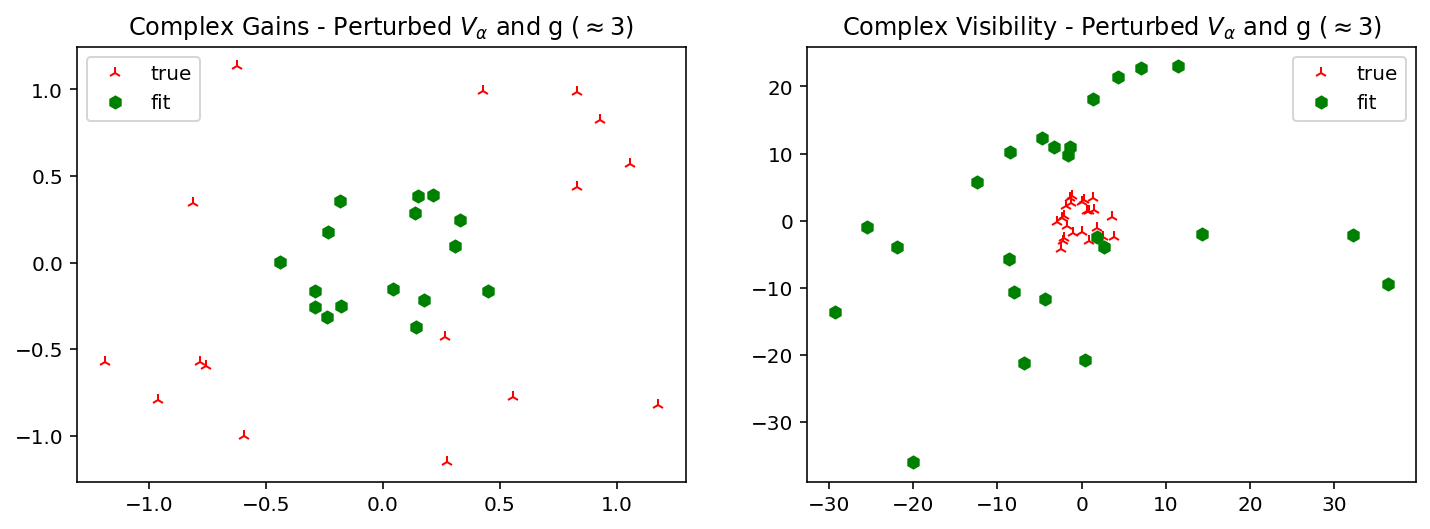

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].set_title('Complex Gains - %s' % title_mod)
axes[0].plot(tgain.real, tgain.imag, 'r2', label='true')
axes[0].plot(garr.real, garr.imag, 'gh', label='fit')
axes[0].legend();

axes[1].set_title('Complex Visibility - %s' % title_mod)
axes[1].plot(valpha.real, valpha.imag, 'r2', label='true')
axes[1].plot(varr.real, varr.imag, 'gh', label='fit')
axes[1].legend();

In [50]:
# fig, axes = plt.subplots(ncols=2, figsize=(12,4))

# axes[0].set_title('Complex Gains - %s' % title_mod)
# axes[0].plot(tgain.real, 'r.', label='true')
# axes[0].plot(tgain.imag, 'b.', label='true')
# axes[0].plot(garr.real, 'rx', label='fit')
# axes[0].plot(garr.imag, 'bx', label='fit')
# axes[0].legend();

# axes[1].set_title('Complex Visibility - %s' % title_mod)
# axes[1].plot(valpha.real, 'r.', label='true')
# axes[1].plot(valpha.imag, 'b.', label='true')
# axes[1].plot(varr.real, 'rx', label='fit')
# axes[1].plot(varr.imag, 'bx', label='fit')
# axes[1].legend();

In [51]:
def chimincal(iter_max, g0, v0):
    y_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)
    score = np.zeros(iter_max)
    chisqr = np.zeros(iter_max)
    garr = g0.copy()
    varr = v0.copy()
    N = 1
    
    for n in tqdm(range(iter_max)):    
        gprime = np.zeros(telescope_number, dtype=np.complex128)
        numer = np.zeros_like(gprime)
        denom = np.zeros_like(gprime)
        for i in range(telescope_number):
            for k in range(telescope_number):
                if i==k:
                    continue
                else:
                    v_indx = get_baseline_indx(i,k)
                    if i < k:
                        vterm = varr[v_indx]
                    else:
                        vterm = np.conj(varr[v_indx])
                    g1 = garr[i]
                    g1c = np.conj(g1)
                    g2 = garr[k]
                    g2c = np.conj(g2)
                    vc = np.conj(vterm)
                    numer[i] += observation_baselines[i,k]*g2*vc-g1*np.abs(g2*vterm)**2-2*np.abs(g1)**2*g1+2*N*(g1)
                    denom[i] += np.abs(g2*vterm)**2+2*(2*np.abs(g1)**2+g1*g1c - N)
            gprime[i] = numer[i]/denom[i]
            
        garr += gprime
            
        vprime = np.zeros(n_bases, dtype=np.complex128)
        for i in range(n_bases):
            indxs = np.where(redundant_baselines[i]==1)
            clean_l = []
            clean_k = []
            for l,k in zip(*indxs):
                if l < k:
                    clean_l.append(l)
                    clean_k.append(k)
            new_indx = (clean_l, clean_k)
            numer = (observation_baselines[new_indx]).sum()
            denom = (garr[clean_l]*np.conj(garr[clean_k])).sum()
            vprime[i] = numer/denom
            
        varr = vprime
        
        
        y_ij, _ = make_uv_points(garr, varr, noise_amp=0, noise_sig=0)

        score[n] = np.linalg.norm(y_ij - observation_baselines)
        chisqr[n] = (np.abs(observation_baselines - y_ij)**2).sum()
        
    return garr, varr, score, chisqr, n

In [52]:
def simplechical(iter_max, g0, v0):
    y_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)
    vprime = np.zeros(n_bases, dtype=np.complex128)
    garr = g0.copy()
    varr = v0.copy()
    vinit = v0.copy()
    ginit = g0.copy()
    N = 1
        
    for n in tqdm(range(iter_max)):    
        gprime = np.zeros(telescope_number, dtype=np.complex128)
        numer = np.zeros_like(gprime)
        denom = np.zeros_like(gprime)
        for i in range(telescope_number):
            for k in range(telescope_number):
                if i==k:
                    continue
                else:
                    v_indx = get_baseline_indx(i,k)
                    if i < k:
                        vterm = vinit[v_indx]
                    else:
                        vterm = np.conj(vinit[v_indx])
                    g1 = garr[i]
                    g1c = np.conj(g1)
                    g2 = garr[k]
                    g2c = np.conj(g2)
                    vc = np.conj(vterm)
                    numer[i] += observation_baselines[i,k]*g2*vc-g1*np.abs(g2*vterm)**2-2*np.abs(g1)**2*g1+2*N*(g1)
                    denom[i] += np.abs(g2*vterm)**2+2*(2*np.abs(g1)**2+g1c*g1c - N)
            gprime[i] = numer[i]/denom[i]
            
        garr += gprime
        
        for i in range(n_bases):
            indxs = np.where(redundant_baselines[i]==1)
            clean_l = []
            clean_k = []
            for l,k in zip(*indxs):
                if l > k:
                    clean_l.append(l)
                    clean_k.append(k)
            new_indx = (clean_l, clean_k)
            numer = (observation_baselines[new_indx]).sum()
            denom = (garr[clean_l]*np.conj(garr[clean_k])).sum()
            vprime[i] = numer/denom - varr[i]

        varr += vprime
        
    y_ij, _ = make_uv_points(garr, varr, noise_amp=0, noise_sig=0)

    score = np.linalg.norm(y_ij - observation_baselines)
    chisqr = (np.abs(observation_baselines - y_ij)**2).sum()
    
    print(chisqr)
    return garr, varr

In [1886]:
iter_max = 50

# g0 = 1*np.exp(1j*(gain_phase + (np.random.random(16)*2-1)/10))
# g0 = 1*np.exp(1j*rand_phases(telescope_number))
# g0 = 1*np.exp(1j*gain_phase)
g0 = tgain.copy()
# v0 = 3*np.exp(1j*rand_phases(n_bases))
v0 = valpha.copy()
print(tgain[0])

(-0.9776774711914589-0.037925510846316894j)


In [2391]:
garr, varr, score, chisqr, finiters = chimincal(iter_max, g0, v0)
# garr, varr = simplechical(100, g0, v0)

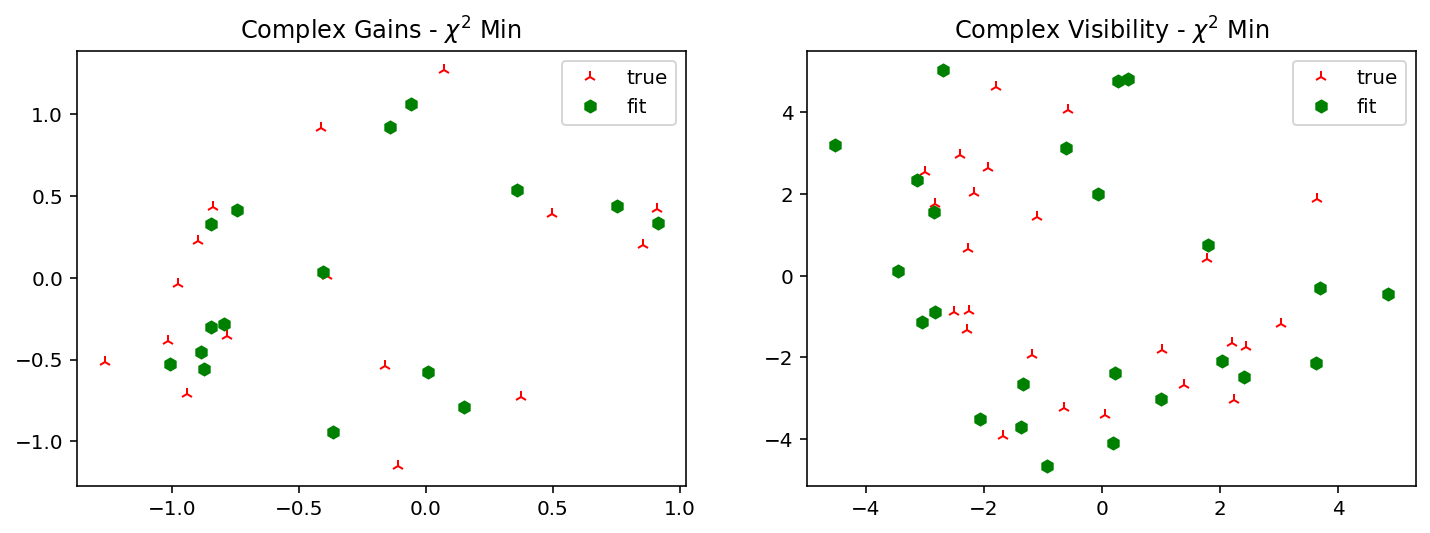

In [2392]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].set_title('Complex Gains - %s' % title_mod)
axes[0].plot(tgain.real, tgain.imag, 'r2', label='true')
axes[0].plot(garr.real, garr.imag, 'gh', label='fit')
axes[0].legend();

axes[1].set_title('Complex Visibility - %s' % title_mod)
axes[1].plot(valpha.real, valpha.imag, 'r2', label='true')
axes[1].plot(varr.real, varr.imag, 'gh', label='fit')
axes[1].legend();

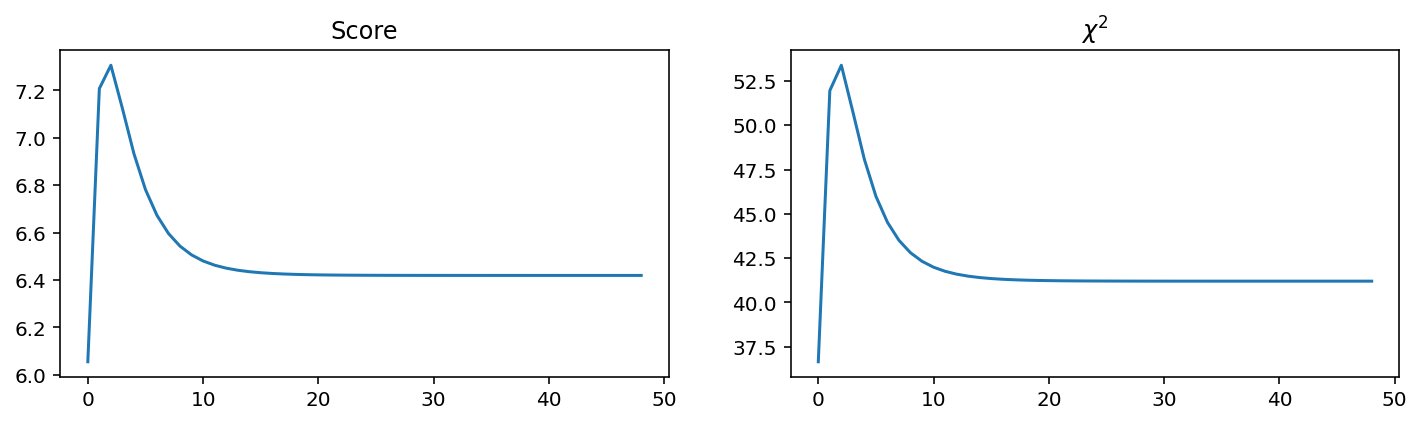

In [2393]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

axes[0].plot(score[:finiters])
axes[0].set_title("Score")

axes[1].plot(chisqr[:finiters])
axes[1].set_title(r"$\chi^2$");

In [1899]:
# Chi2 Min - V array anze
garr = tgain.copy()
varr = valpha.copy()
for n in range(2):
    vprime = np.zeros(n_bases, dtype=np.complex128)
    for i in range(n_bases):
        indxs = np.where(redundant_baselines[i]==1)
        clean_l = []
        clean_k = []
        for l,k in zip(*indxs):
            if l < k:
                clean_l.append(l)
                clean_k.append(k)
        new_indx = (clean_l, clean_k)
        numer = (observation_baselines[new_indx]).sum()
        denom = (garr[clean_l]*np.conj(garr[clean_k])).sum()
        vprime[i] = numer/denom
    varr = vprime

In [1864]:
# Chi2 Min - G array anze
garr = g0.copy()
varr = v0.copy()
for n in range(50):
    gprime = np.zeros(telescope_number, dtype=np.complex128)
    numer = np.zeros_like(gprime)
    denom = np.zeros_like(gprime)
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            else:
                v_indx = get_baseline_indx(i,k)
                if i < k:
                    vterm = varr[v_indx]
                else:
                    vterm = np.conj(varr[v_indx])
                g2 = np.conj(garr[k])
                numer[i] += observation_baselines[i,k]*np.conj(g2)*np.conj(vterm)
                denom[i] += np.abs(g2*vterm)**2
                
        gprime[i] = numer[i]/denom[i]
    garr = gprime

In [707]:
orig_uv, _ = make_uv_points(tgain, valpha, noise_amp=0, noise_sig=0)

In [708]:
scaled_uv, _ = make_uv_points(tgain*3, valpha*1/9, noise_amp=0, noise_sig=0)

In [1523]:
# Chi2 Min - G array anze w/ g norm to 1
garr = tgain.copy()*5
varr = valpha.copy()*1/25
N=1
normal_scale = 1
penalty_scale = 5
score = []
for n in range(100):
    gprime = np.zeros(telescope_number, dtype=np.complex128)
    numer = np.zeros_like(gprime)
    denom = np.zeros_like(gprime)
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            else:
                v_indx = get_baseline_indx(i,k)
                if i < k:
                    vterm = varr[v_indx]
                else:
                    vterm = np.conj(varr[v_indx])
                g1 = garr[i]
                g1c = np.conj(g1)
                g2 = garr[k]
                g2c = np.conj(g2)
                vc = np.conj(vterm)
#                 numer[i] += observation_baselines[i,k]*g2*vc-g1*np.abs(g2*vterm)**2
#                 denom[i] += np.abs(g2*vterm)**2

                numer[i] += observation_baselines[i,k]*g2*vc-g1*np.abs(g2*vterm)**2-1*penalty_scale*(g1*g1c*g1 - N*g1)
                denom[i] += np.abs(g2*vterm)**2+1*penalty_scale*(g1*g1c+g1c*g1c)

#                 numer[i] += normal_scale*(observation_baselines[i,k]*g2*vc-g1*np.abs(g2*vterm)**2)-2*penalty_scale*(np.sum(garr*garr*np.conj(garr)) - N*np.sum(garr))
#                 denom[i] += normal_scale*(np.abs(g2*vterm)**2)+2*penalty_scale*(np.sum(np.conj(garr)*np.conj(garr)) + 2*np.sum(np.abs(garr)**2) - N)
        
#                 numer[i] += observation_baselines[i,k]*g2*vc-g1*np.abs(g2*vterm)**2 - 2*penalty_scale*(np.sum(garr*garr*np.conj(garr)) - N*np.sum(garr))
#                 denom[i] += np.abs(g2*vterm)**2+2*penalty_scale*(np.sum(np.conj(garr)*np.conj(garr)) + np.sum(np.abs(garr)**2))
                
                
        gprime[i] = numer[i]/denom[i]
    garr += gprime*.1
    score.append(np.linalg.norm(tgain - garr)**2)

In [1415]:
# Chi2 Min - G & V array anze w/ g norm to 1
garr = g0.copy()
varr = v0.copy()
N=1
for n in range(10):
    gprime = np.zeros(telescope_number, dtype=np.complex128)
    numer = np.zeros_like(gprime)
    denom = np.zeros_like(gprime)
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            else:
                v_indx = get_baseline_indx(i,k)
                if i < k:
                    vterm = varr[v_indx]
                else:
                    vterm = np.conj(varr[v_indx])
                g1 = garr[i]
                g1c = np.conj(g1)
                g2 = garr[k]
                g2c = np.conj(g2)
                vc = np.conj(vterm)
                numer[i] += observation_baselines[i,k]*g2*vc-g1*np.abs(g2*vterm)**2-2*np.abs(g1)**2*g1c+2*N*(g1c)
                denom[i] += np.abs(g2*vterm)**2+2*(2*np.abs(g1)**2 + g1c**2 - N)
                
        gprime[i] = numer[i]/denom[i]
    
    vprime = np.zeros(n_bases, dtype=np.complex128)
    for i in range(n_bases):
        indxs = np.where(redundant_baselines[i]==1)
        clean_l = []
        clean_k = []
        for l,k in zip(*indxs):
            if l < k:
                clean_l.append(l)
                clean_k.append(k)
        new_indx = (clean_l, clean_k)
        numer = (observation_baselines[new_indx]).sum()
        denom = (garr[clean_l]*np.conj(garr[clean_k])).sum()
        vprime[i] = numer/denom
    varr = vprime
    garr += gprime

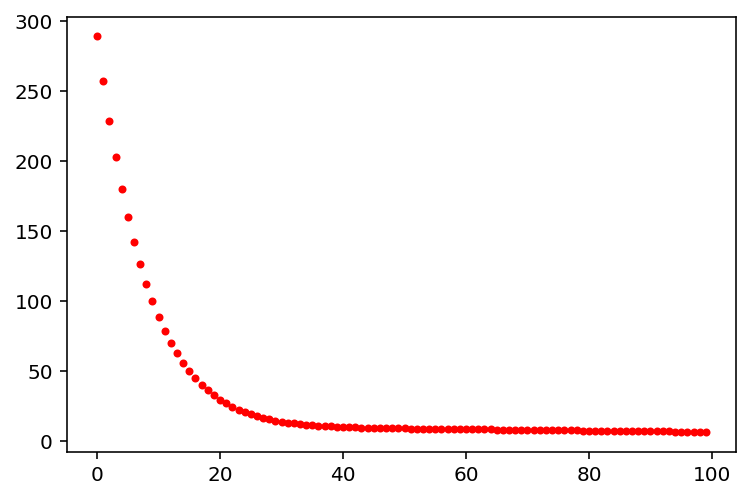

In [1524]:
plt.plot(score, 'r.')

In [1525]:
print(np.abs(observation_baselines[i,k]*g2*vc-g1*np.abs(g2*vterm)**2), np.abs(1*np.abs(g1)**2*g1+1*N*(g1)))
print(np.abs(g2*vterm)**2,  np.abs(2*(2*g1*g1c+g1c*g1c - N)))

# 
# 

0.013448094603420039 2.0991108173728725
0.013128672208955664 4.260019274247402


In [1526]:
print(np.log(np.abs(garr - tgain)))
print(np.mean(np.abs(garr)))

[-0.25207423 -0.45892314 -0.77764055 -0.8893945  -0.21437766 -0.13987278
 -1.29844952 -0.29869637 -0.06597704 -0.5079743  -0.48164109 -0.51374052
 -0.84773472 -0.46074839 -0.72816895 -1.02301572]
1.0213072221944914


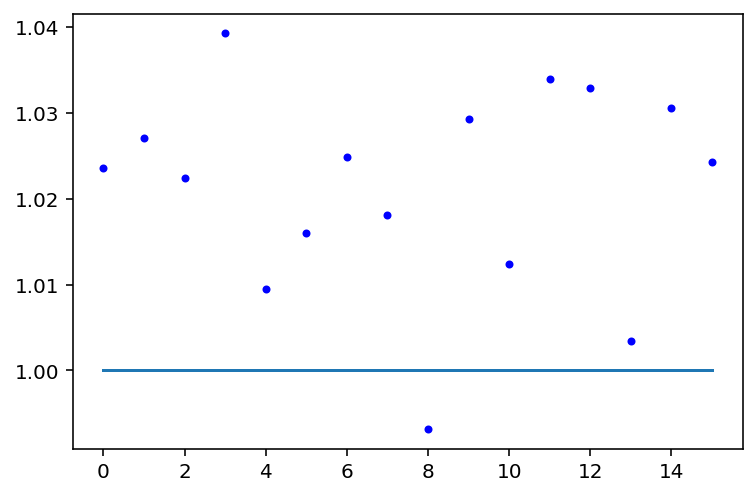

In [1527]:
plt.plot(np.abs(garr), 'b.')
plt.plot(np.ones(telescope_number))

In [1528]:
print(np.log(np.abs(varr - valpha)))
print(np.mean(np.abs(varr))/np.mean(np.abs(valpha)))

[0.9814297  0.82961234 1.13958616 0.63263172 0.71538478 1.29813901
 1.05223613 1.24536813 0.71180957 0.96154753 0.40427753 1.02429765
 0.69127318 1.07485303 0.72986476 1.26622441 0.50875496 0.49603071
 1.48121312 1.09600835 1.2495111  1.53418267 1.23375842 1.29040468]
0.04000000000000001


In [1529]:
title_mod = r"$\chi^2$ Min"

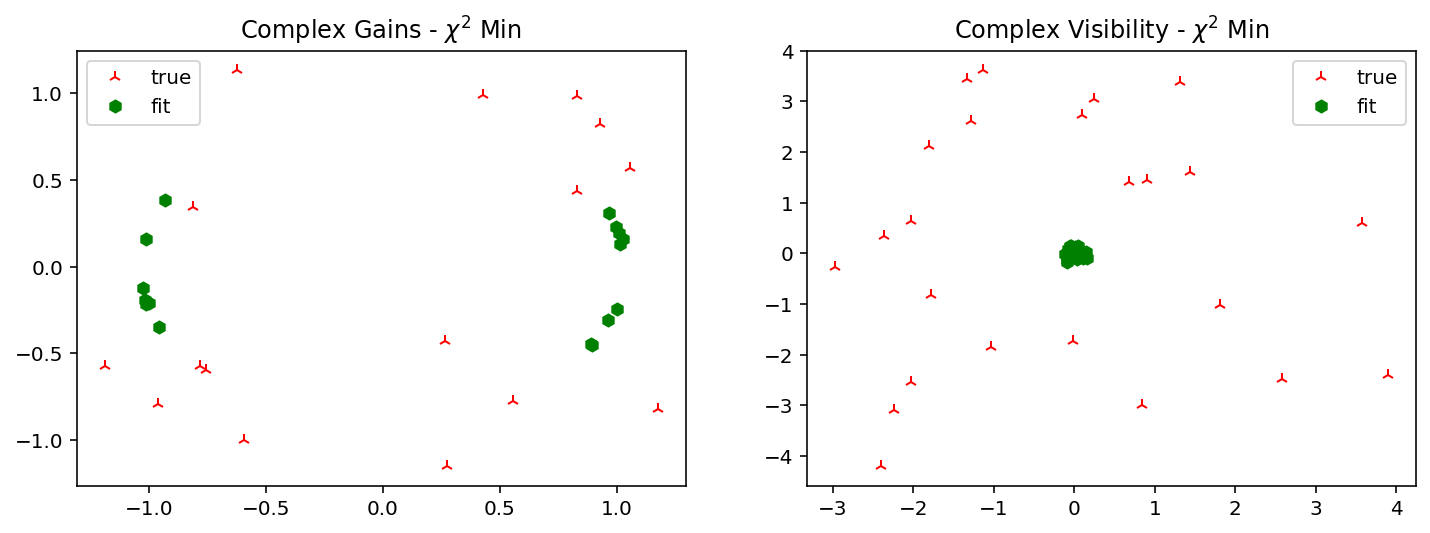

In [1530]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].set_title(r'Complex Gains - %s' % title_mod)
axes[0].plot(tgain.real, tgain.imag, 'r2', label='true')
axes[0].plot(garr.real, garr.imag, 'gh', label='fit')
# axes[0].plot(garr.real[-1], garr.imag[-1], 'b*', label='last')
axes[0].legend();

axes[1].set_title(r'Complex Visibility - %s' % title_mod)
axes[1].plot(valpha.real, valpha.imag, 'r2', label='true')
axes[1].plot(varr.real, varr.imag, 'gh', label='fit')
axes[1].legend();

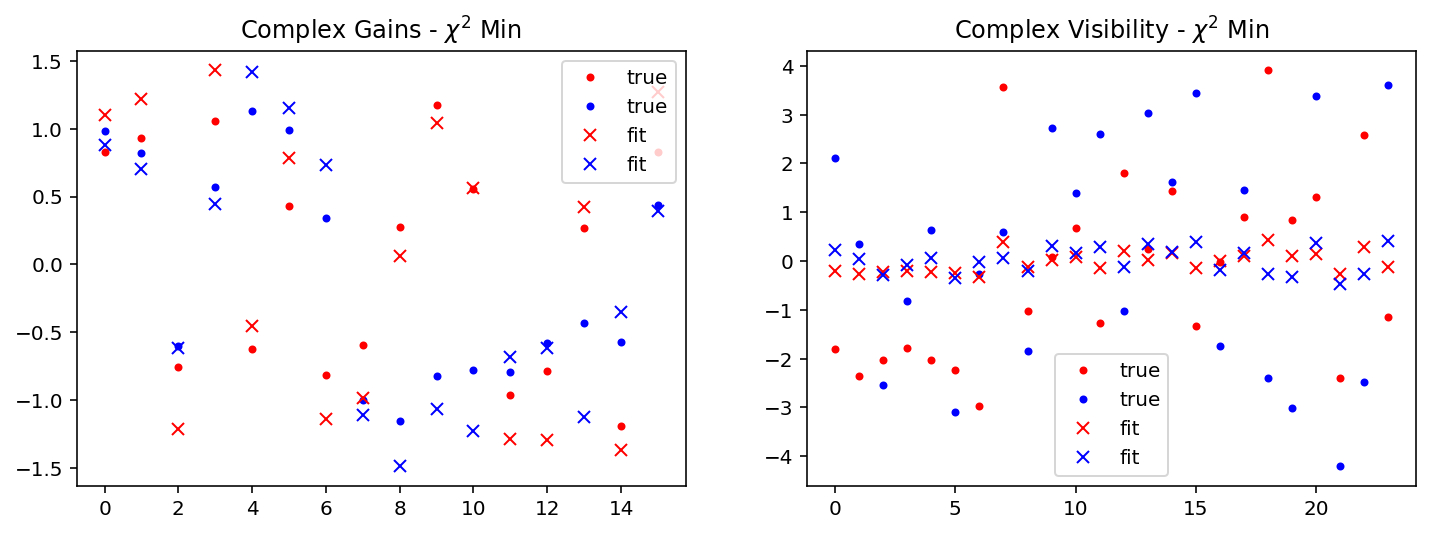

In [1491]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].set_title('Complex Gains - %s' % title_mod)
axes[0].plot(tgain.real, 'r.', label='true')
axes[0].plot(tgain.imag, 'b.', label='true')
axes[0].plot(garr.real, 'rx', label='fit')
axes[0].plot(garr.imag, 'bx', label='fit')
axes[0].legend();

axes[1].set_title('Complex Visibility - %s' % title_mod)
axes[1].plot(valpha.real, 'r.', label='true')
axes[1].plot(valpha.imag, 'b.', label='true')
axes[1].plot(varr.real, 'rx', label='fit')
axes[1].plot(varr.imag, 'bx', label='fit')
axes[1].legend();